<a href="https://colab.research.google.com/github/ajsanjoaquin/COVID-19-Scanner/blob/master/NCOV19_X_ray_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coronavirus 2019 (COVID-19) Classifer using Posteroanterior views (PA) of Chest Radiograph Images (CXR)
Accompanying information [here](https://towardsdatascience.com/using-deep-learning-to-detect-ncov-19-from-x-ray-images-1a89701d1acd).

NOTICE: This notebook is provided as-is with no guarantee of accurate diagnosis. The model was trained on heavily skewed data and is not suitable for deployment. It is currently meant to be a proof of concept for now. All images used were publicly accessible and usable at the time of training.

In [0]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 352 (delta 16), reused 26 (delta 5), pack-reused 311
Receiving objects: 100% (352/352), 58.02 MiB | 42.50 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [0]:
import pandas as pd
import numpy as np
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion

#Preprocessing
##Extracting Images 

In [0]:
metadata_path='covid-chestxray-dataset/metadata.csv'
df=pd.read_csv(metadata_path)

#types we're interested in
covid_patients=df['finding']=='COVID-19'
CT=df['view']=='CT'
PA=df['view']=='PA'

# %%
df[covid_patients & CT].shape
df[covid_patients & PA].shape
# %%
PA_covid=df[covid_patients & PA]
Others=df[~covid_patients & PA]
covid_files=[files for files in PA_covid['filename']]
other_files=[files for files in Others['filename']]

In [0]:
#our test folder. manually included files via upload.
test_files=[file for file in sorted(os.listdir('test'))]
df_test=pd.DataFrame(test_files, columns=['filename'])

In [0]:
#create data folder and positive & negative cases folder, and test folder
destpath = 'data/covid','data/other', 'data/test'
srcpath = 'covid-chestxray-dataset/images'

for root, dirs, files in os.walk(srcpath):
  if not os.path.isdir(destpath[0]):
    os.makedirs(destpath[0])
  if not os.path.isdir(destpath[1]):
    os.makedirs(destpath[1])
  if not os.path.isdir(destpath[2]):
    os.makedirs(destpath[2])
  for file in files:
    if file in covid_files:
      shutil.copy(os.path.join(root, file),destpath[0])
    if file in other_files:
      shutil.copy(os.path.join(root,file),destpath[1])
    if file in test_files:
      shutil.copy(os.path.join(root,file)),destpath[2]
      

In [0]:
#see number of files
path, dirs, files2 = os.walk("data/other").__next__()
path, dirs, files1 = os.walk("data/covid").__next__()
path, dirs, files3 = os.walk("data/test").__next__()
print("Number of images in Other: {}".format(len(files2)),"Number of images in Covid: {}".format(len(files1)),"Number of images in Test Set: {}".format(len(files3)) )

Number of images in Other: 226 Number of images in Covid: 35


## Loading and Splitting Data
We first declare the labels to be used (corresponding with the folder names). We then wrap it around a dataloader from fastai. 

We allocate 20% of the data for validation, and we reserve a test set from a folder called "test". We resize all images to 512 x 512 pixels. 

In [0]:
classes=['covid','other']

In [0]:
#include a test folder named test before running this block
#function assumes test set is located in the path (first arg) by default
data = ImageDataBunch.from_folder('data', train=".", valid_pct=0.25,test='test',
        ds_tfms=get_transforms(), bs=8, size=512, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['covid', 'other']

In [0]:
#show size of our datasets
print(len(data.train_ds),len(data.valid_ds),len(data.test_ds.x))

196 65 78


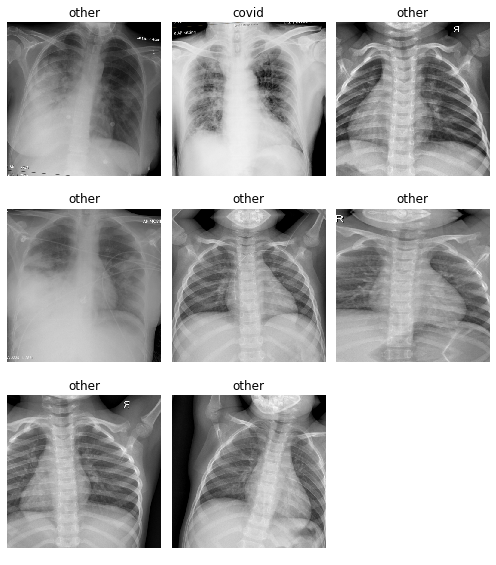

In [0]:
#sample of our images with labels
data.show_batch(rows=5, figsize=(7,8))

#Training
We use a Resnet 50 for transfer learning.
Initially we run the fit one cycle policy for a few epochs and then using fastai's **lrfinder** to find an optimal range for our learning rate.

We use precision and recall to measure the incidents of false positives and false negatives, as well as AUC to account for performance given the skewed data.

In [0]:
precision=Precision()
recall=Recall()
AUC=AUROC()

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=(accuracy,precision,recall,AUC))

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,1.452687,2.755551,0.323077,1.000000,0.169811,0.918239,00:34


At this stage, we realize the model is underfitting, so we continue to progressively increase the number of epochs from here on in an effort to reduce training loss while maintaining the low validation loss.

In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.767465,0.476666,0.784615,1.000000,0.735849,0.992138,00:31
1,0.609159,0.180127,0.907692,0.979592,0.905660,0.979560,00:31


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


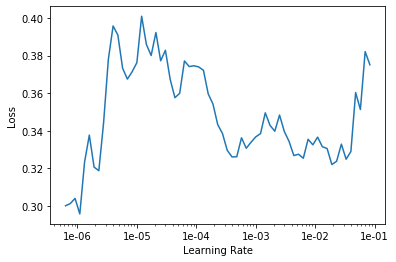

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#@title Defining custom checkpoints
#Customizing where our checkpoints are saved and loaded
#if not os.path.isdir('checkpoints'): 
 # os.mkdir('checkpoints')
os.mkdir('check')
def custom_path_save(self, name:PathOrStr, path='check', return_path:bool=False, with_opt:bool=True):
        "Save model and optimizer state (if `with_opt`) with `name` to `self.model_dir`."
        # delete #  path = self.path/self.model_dir/f'{name}.pth'
        # my addition: start
        if path=='': path = self.path/self.model_dir/f'{name}.pth'
        else: path = f'{path}/{name}.pth'
        # end
        if not with_opt: state = get_model(self.model).state_dict()
        else: state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
        torch.save(state, path)
        if return_path: return path

def custom_path_load(self, name:PathOrStr, path='check', device:torch.device=None, strict:bool=True, with_opt:bool=None,purge=False):
        "Load model and optimizer state (if `with_opt`) `name` from `self.model_dir` using `device`."
        if device is None: device = self.data.device
        # delete # state = torch.load(self.path/self.model_dir/f'{name}.pth', map_location=device)
        # my addition: start
        if path=='': path = self.path/self.model_dir/f'{name}.pth'
        else: path = f'{path}/{name}.pth'
        state = torch.load(path, map_location=device) 
        # end
        if set(state.keys()) == {'model', 'opt'}:
            get_model(self.model).load_state_dict(state['model'], strict=strict)
            if ifnone(with_opt,True):
                if not hasattr(self, 'opt'): opt = self.create_opt(defaults.lr, self.wd)
                try:    self.opt.load_state_dict(state['opt'])
                except: pass
        else:
            if with_opt: warn("Saved filed doesn't contain an optimizer state.")
            get_model(self.model).load_state_dict(state, strict=strict)
        return self

learn.save = custom_path_save.__get__(learn)
learn.load = custom_path_load.__get__(learn)
model_path ='check'

In [0]:
learn.save('Corona_model_stage1')

In [0]:
#learn.load('Corona_model_stage1')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(9e-07,1e-06))

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.364490,0.198903,0.907692,0.912281,0.981132,0.949686,00:32
1,0.399531,0.238177,0.861538,1.000000,0.830189,0.987421,00:32
2,0.363702,0.195634,0.907692,1.000000,0.886792,0.992138,00:32
3,0.378611,0.154305,0.923077,0.944444,0.962264,0.985849,00:32
4,0.397570,0.182065,0.938462,0.962264,0.962264,0.974843,00:31
5,0.404387,0.157945,0.907692,0.943396,0.943396,0.982704,00:32
6,0.405342,0.164380,0.953846,0.980769,0.962264,0.982704,00:31
7,0.417745,0.136051,0.953846,0.946429,1.000000,0.990566,00:32
8,0.437893,0.137975,0.953846,0.962963,0.981132,0.990566,00:32
9,0.402558,0.152316,0.938462,0.945455,0.981132,0.988994,00:32


In [0]:
learn.save('Corona_model_stage2')

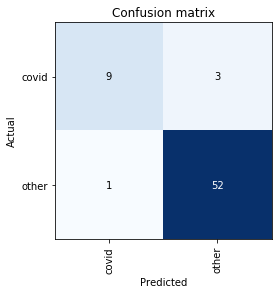

In [0]:
#confusion matrix for the first 2 iterations
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
ClassConfusion(interp, classes, is_ordered=False, figsize=(8,8))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


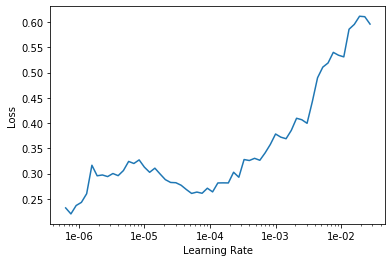

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(30, max_lr=slice(6e-07,7e-06))

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.329083,0.161188,0.923077,0.980000,0.924528,0.988994,00:31
1,0.322466,0.184026,0.923077,1.000000,0.905660,0.993711,00:31
2,0.377909,0.156069,0.984615,1.000000,0.981132,0.993711,00:31
3,0.339729,0.185341,0.907692,1.000000,0.886792,0.993711,00:31
4,0.343446,0.154403,0.923077,0.928571,0.981132,0.987421,00:31
5,0.320960,0.201964,0.876923,1.000000,0.849057,0.996855,00:31
6,0.314984,0.139085,0.938462,0.962264,0.962264,0.993711,00:31
7,0.338542,0.123679,0.969231,0.963636,1.000000,0.998428,00:31
8,0.332734,0.143998,0.969231,1.000000,0.962264,1.000000,00:30
9,0.345055,0.122995,0.984615,0.981481,1.000000,0.992138,00:31


In [0]:
learn.save('Corona_model_stage3.pth')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


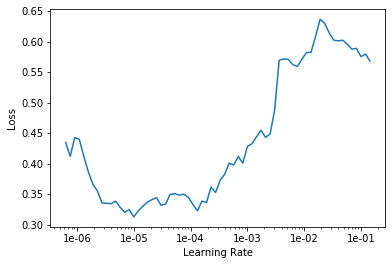

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(40, max_lr=slice(8e-06,1e-05))

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.202330,0.129510,0.969231,1.000000,0.962264,1.000000,00:29
1,0.307139,0.130274,0.953846,0.946429,1.000000,0.993711,00:30
2,0.329779,0.149713,0.938462,0.962264,0.962264,0.987421,00:31
3,0.368552,0.165314,0.953846,0.980769,0.962264,0.987421,00:30
4,0.293627,0.108407,1.000000,1.000000,1.000000,1.000000,00:30
5,0.275742,0.113035,0.969231,0.963636,1.000000,0.998428,00:31
6,0.292897,0.128666,0.953846,0.962963,0.981132,0.988994,00:30
7,0.277679,0.121344,0.969231,0.963636,1.000000,0.993711,00:30
8,0.318157,0.117274,0.953846,0.962963,0.981132,0.990566,00:30
9,0.276515,0.137329,0.953846,0.962963,0.981132,0.976415,00:31


In [0]:
learn.save('Corona_model_stage4.pth')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


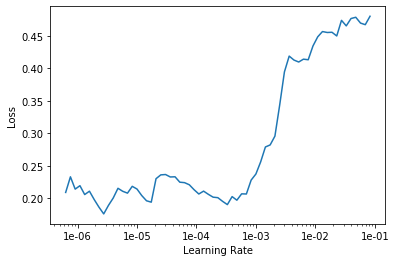

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=2e-06)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.147189,0.147491,0.953846,0.962963,0.981132,0.957547,00:30
1,0.156640,0.138794,0.953846,0.962963,0.981132,0.971698,00:30
2,0.155739,0.169582,0.938462,0.962264,0.962264,0.979560,00:30
3,0.160096,0.160149,0.938462,0.962264,0.962264,0.948113,00:30
4,0.187604,0.159831,0.938462,0.962264,0.962264,0.966981,00:29


In [0]:
learn.save('Corona_model_stage5')

# Results on Validation Set and Predictions on Test Set

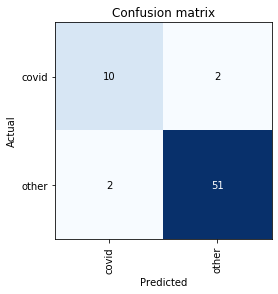

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
preds, _ = learn.get_preds(ds_type = DatasetType.Test, ordered=True)

In [0]:
df_test

In [0]:
#WARNING: PREDICTIONS ARE NOT SORTED AND DO NOT MATCH THEIR ACTUAL CORRESPONDING IMAGES
'''
model_classes = learn.data.classes
preds = preds.tolist()
confidences = [{c: p for c,p*100 in zip(model_classes, probs)} for probs in preds]
final_df = pd.DataFrame({'ID_code': df_test['filename'], 'target': confidences})
final_df.to_csv('NCOV_test_results.csv', header=True, index=False)
'''



In [0]:
#safer to use a dictionary data structure
#save predictions on test set in csv
images={filename:open_image('data/test/'+filename) for filename in test_files}
results={filename:learn.predict(images[filename]) for filename in test_files}
final_df=pd.DataFrame.from_dict(results,orient='index')
final_df.to_csv('NCOV_test_results.csv', header=True)
